# Unsupervised Learning: Data Analysis

* **Disciplines:** Unsupervised Learning, dimensionality reduction and recommender systems.
* **Data:** Movies rated by users (https://grouplens.org/datasets/movielens/)

> F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns

In [33]:
from biplot import biplot

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer, KNNImputer

## Load, clean and wrangle data

In [4]:
df_movies = pd.read_csv('../data/ml-latest-small/movies.csv', index_col='movieId')

In [5]:
df_movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [6]:
df_ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')

In [7]:
df_ratings = df_ratings.merge(df_movies['title'], on='movieId')

In [8]:
# filter for movies that have at minimum N raitings
min_rating_count = 10
# https://stackoverflow.com/a/29791952
df_ratings['raiting_count_per_movie'] = df_ratings.groupby('movieId')['movieId'].transform('count')
df_ratings = df_ratings[df_ratings.raiting_count_per_movie > min_rating_count]

In [9]:
df_ratings.head()

,userId,movieId,rating,timestamp,title,raiting_count_per_movie
0,1,1,4.0,964982703,Toy Story (1995),215
1,5,1,4.0,847434962,Toy Story (1995),215
2,7,1,4.5,1106635946,Toy Story (1995),215
3,15,1,2.5,1510577970,Toy Story (1995),215
4,17,1,4.5,1305696483,Toy Story (1995),215


* *https://stackoverflow.com/a/39358924*
* *https://stackoverflow.com/q/45312377*

In [10]:
M_movie_genres = df_movies.genres.str.get_dummies().drop('(no genres listed)', axis=1)
M_movie_genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
M_ratings = df_ratings.pivot(columns='title', values='rating', index='userId').dropna(how='all')
M_ratings.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data analysis

### Principal Component Analysis (PCA) of user raiting matrix

> *Wikipedia: "(...) it can be shown that the principal components are eigenvectors of the data's covariance matrix."*

* Before applying PCA, it is often a good idea to remove mean and normalize variance of each dimension. In this case we omit this step, because each dimension (movie) has a fixed and meaningful value range of [0,1]. StandardScaler would be contraproductive, because a value associating to a genre in for one movie would be transformed differently than the same association for another movie.
* PCA cannot deal with missing values.

In [12]:
pca = PCA()
pca.fit(M_movie_genres)
W = pca.transform(M_movie_genres)

Text(0.5, 1.0, 'Biplot')

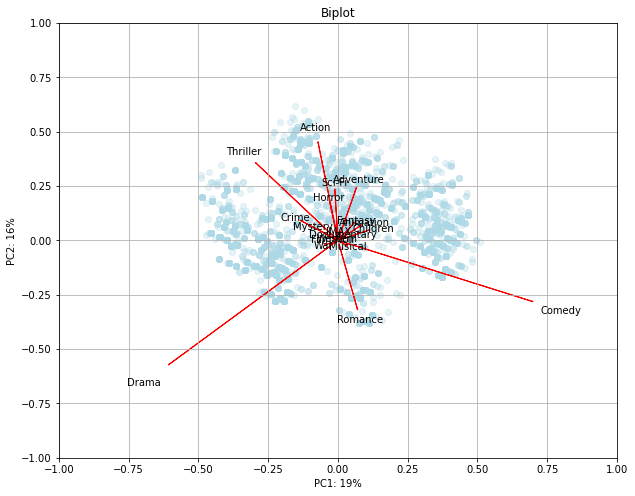

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
biplot(W[:,:2], pca.components_[:2].T, labels=M_movie_genres.columns, ax=ax)
ax.set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]*100:.0f}%")
ax.set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]*100:.0f}%")
ax.set_title('Biplot')

* 19 dimensions (genres) reduced to a 2D plane using its first two principal components.
* The first two components explain 35% (19% + 16%) of the data's variation.
* Two scales with opposite genres can be identified:
    * Romace vs. Action/Thriller
    * Comedy vs. Drama/(Thriller)

### t-SNE: t-distributed stochastic neighbor embedding

Since t-SNE is computationally expensive, we can reduce dimensionality with PCA (Principal Component Analysis).

In [14]:
tsne = TSNE(n_components=2)

In [15]:
T = tsne.fit_transform(W[:,:10]) # use a 10-dim projection based on PCA

In [19]:
M_movie_genres['tsne_1'] = T[:,0]
M_movie_genres['tsne_2'] = T[:,1]

<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

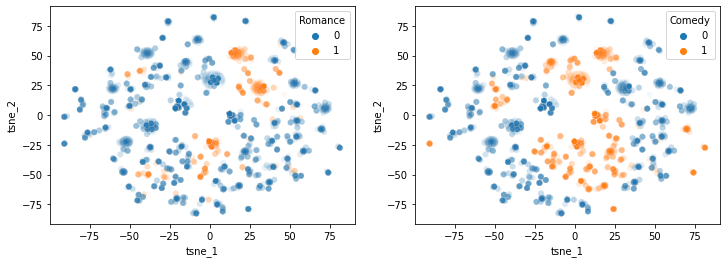

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.scatterplot(data=M_movie_genres, x='tsne_1', y='tsne_2', hue='Romance', legend=True, alpha=0.05, ax=ax[0])
sns.scatterplot(data=M_movie_genres, x='tsne_1', y='tsne_2', hue='Comedy', legend=True, alpha=0.05, ax=ax[1])

* You can observe where t-SNE mapped the genres romance and comedy.

### Clustering (K-means)

In [84]:
inertia = []
silhoutte ncols=
clusters = np.arange(5,50)

for cluster_no in clusters:
    clustering = KMeans(n_clusters= cluster_no)
    clustering.fit(W[:,0:10])
    inertia.append(clustering.inertia_)
    silhoutte.append(silhouette_score(W[:,0:10], clustering.labels_))

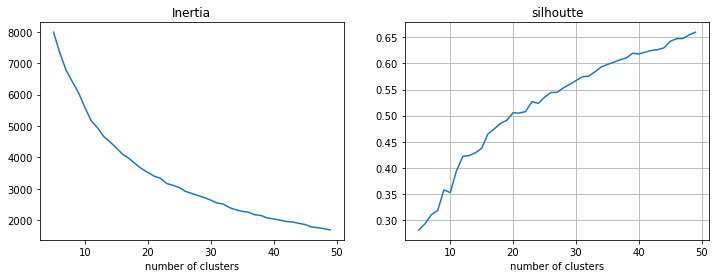

In [88]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(clusters, inertia)
ax[0].set_xlabel('number of clusters')
ax[0].set_title('Inertia')
ax[1].plot(clusters, silhoutte)
ax[1].set_xlabel('number of clusters')
ax[1].set_title('silhoutte')
ax[1].grid()

Choosing 22 clusters:

In [128]:
clustering = KMeans(n_clusters=22)
clustering.fit(W[:,0:10])

KMeans(n_clusters=22)

Text(0.5, 1.0, 'Clusters on t-SNE mapping')

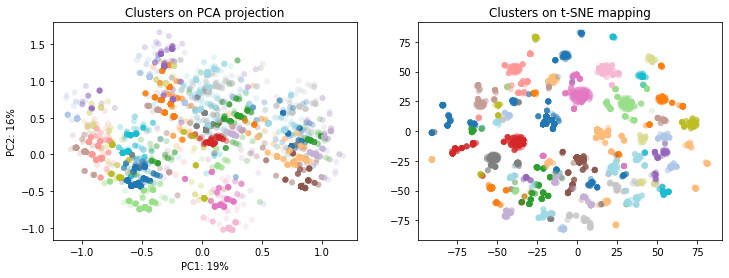

In [157]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

ax[0].scatter(W[:,0], W[:,1], c=clustering.labels_, cmap='tab20', alpha=0.25, edgecolor='none')
ax[0].set_title('Clusters on PCA projection')
ax[0].set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]*100:.0f}%")
ax[0].set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]*100:.0f}%")

ax[1].scatter(M_movie_genres.tsne_1, M_movie_genres.tsne_2, c=clustering.labels_, cmap='tab20', alpha=0.25, edgecolor='none')
ax[1].set_title('Clusters on t-SNE mapping')